In [1]:
import time
import signal
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Markdown # Import 'display' and 'Markdown'
import matplotlib.pyplot as plt
import sys

sys.path.insert(0, str('../../'))
sys.path.insert(0, str('../statistics_core'))

import SuguruSolvers
import SASolver
from stats_analysis import stats

## Funções

In [2]:
def timeout_handler(signum, frame):
    raise Exception('EndOfTime')

def get_pickle_data(file_path):
    with open(file_path, 'rb') as fp:
        data = pickle.load(fp)
    return data

def get_instances():
    # Load instances
    instances = list()
    for root, dirs, files in os.walk('../../instances/generator'):
        for filename in files:
            file_path = os.path.join(root, filename)
            instances.append(file_path)
    return instances

def parse_suguru_binary(path):
    if not os.path.isfile(path):
        raise Exception('Error: invalid file path')

    # Load from file
    with open(path, 'rb') as fp:
        rows = int.from_bytes(fp.read(2))
        cols = int.from_bytes(fp.read(2))
        arr = np.fromfile(fp, dtype=np.int16).reshape(3, rows, cols)
    return arr

def run_solver(solver):
    results = dict()
    instances = get_instances()
    for instance in instances:
        grid, _, regions = parse_suguru_binary(instance)

        # Get puzzle statistics
        tips = np.count_nonzero(grid != 0)
        size = grid.size
        region_count = np.max(regions.flatten())
        
        # 5 Minute timeout
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(30)

        # Solving using the current solver
        solved = False
        timeout = True
        try:
            s = solver(grid, regions)
            start = time.perf_counter()
            solved = s.solve()
            end = time.perf_counter()
            elapsed = end - start
        except Exception as e:
            print('Skipping by timeout...')
            solved = False
            timeout = True

        signal.alarm(0)
        
        if solver not in results:
            results[solver] = {'solved':list(), 'elapsed':list(), 'puzzle':list(), 'tips':list(), 'size':list(), 'region_count':list(), 'timeout':False}
        
        if solved:
            results[solver]['solved'].append(1)
            results[solver]['elapsed'].append(elapsed)
        else:
            results[solver]['solved'].append(0)
            results[solver]['elapsed'].append(np.inf)

        results[solver]['tips'].append(tips)
        results[solver]['puzzle'].append(instance)
        results[solver]['size'].append(size)
        results[solver]['region_count'].append(region_count)
        results[solver]['timeout'] = timeout
        
        if len(results[solver]['solved']) % 100 == 0:
            print('[i] Tested: ', len(results[solver]['solved']))
            
    return results[solver]


## Motor Determinístico

In [3]:
# This might take very long!
# de_stats = evaluate_solver_stats(SuguruSolvers.DeterministicEngine)
de_stats = get_pickle_data('de.pkl')

--- Starting Data Processing and Feature Engineering ---
Total Runs: 1700, Solved Runs: 191
------------------------------
--- Key Performance Metrics ---
1. Overall Success Rate: 0.11 (191/1700)
2. Avg Solving Time (Solved Only): 0.005 s
------------------------------
--- Robust Correlation Analysis ---
Point-Biserial Correlation (r) with SUCCESS RATE:
(* Positive 'r' means higher feature value is correlated with success.)
                      r_success        p_value
tip_density            0.511886  3.491952e-114
tips                  -0.188305   4.939935e-15
size                  -0.196628   2.809878e-16
region_count          -0.200740   6.496701e-17
region_complexity     -0.352013   9.141572e-51
log_difficulty_proxy  -0.438395   8.904424e-81

------------------------------
Pearson Correlation (r) with ELAPSED TIME (Solved Only):
(* Positive 'r' means higher feature value is correlated with longer time.)
                        r_time       p_value
size                  0.775052  1

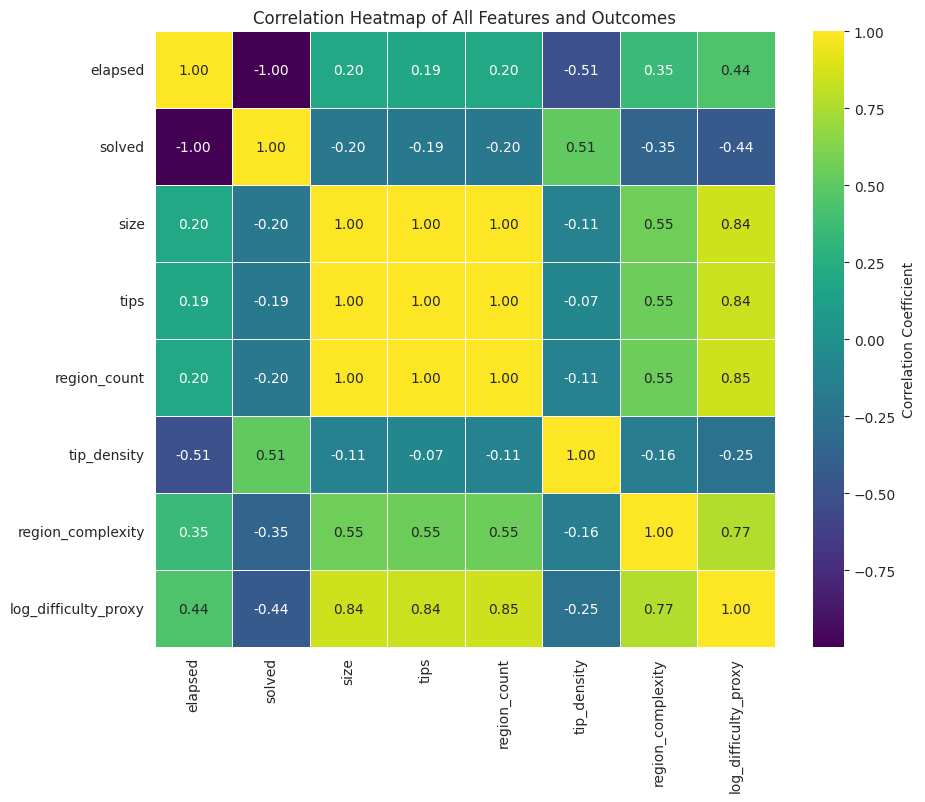


Generating Pair Plot...


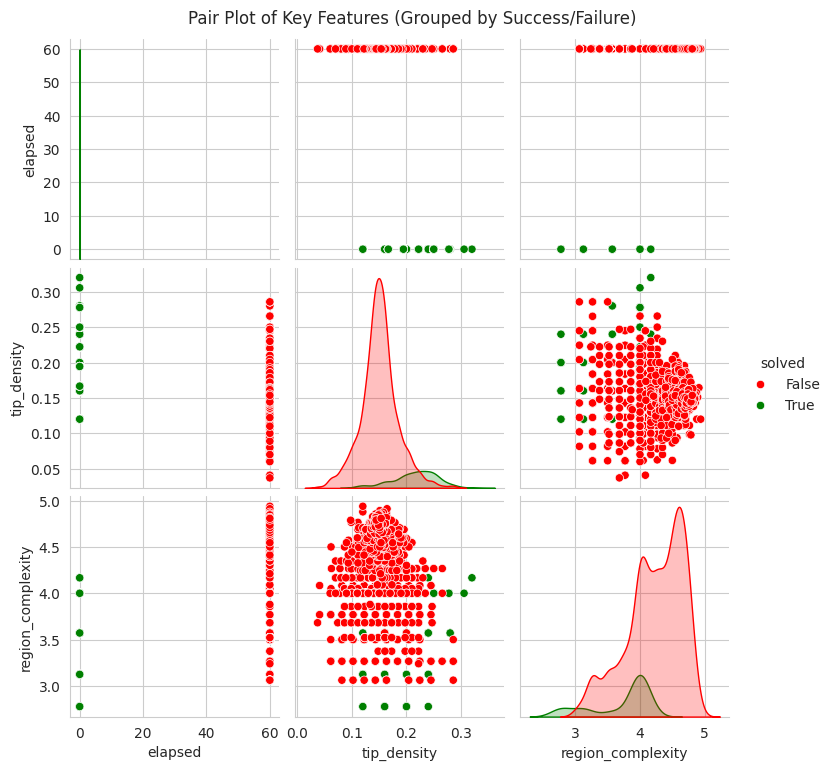

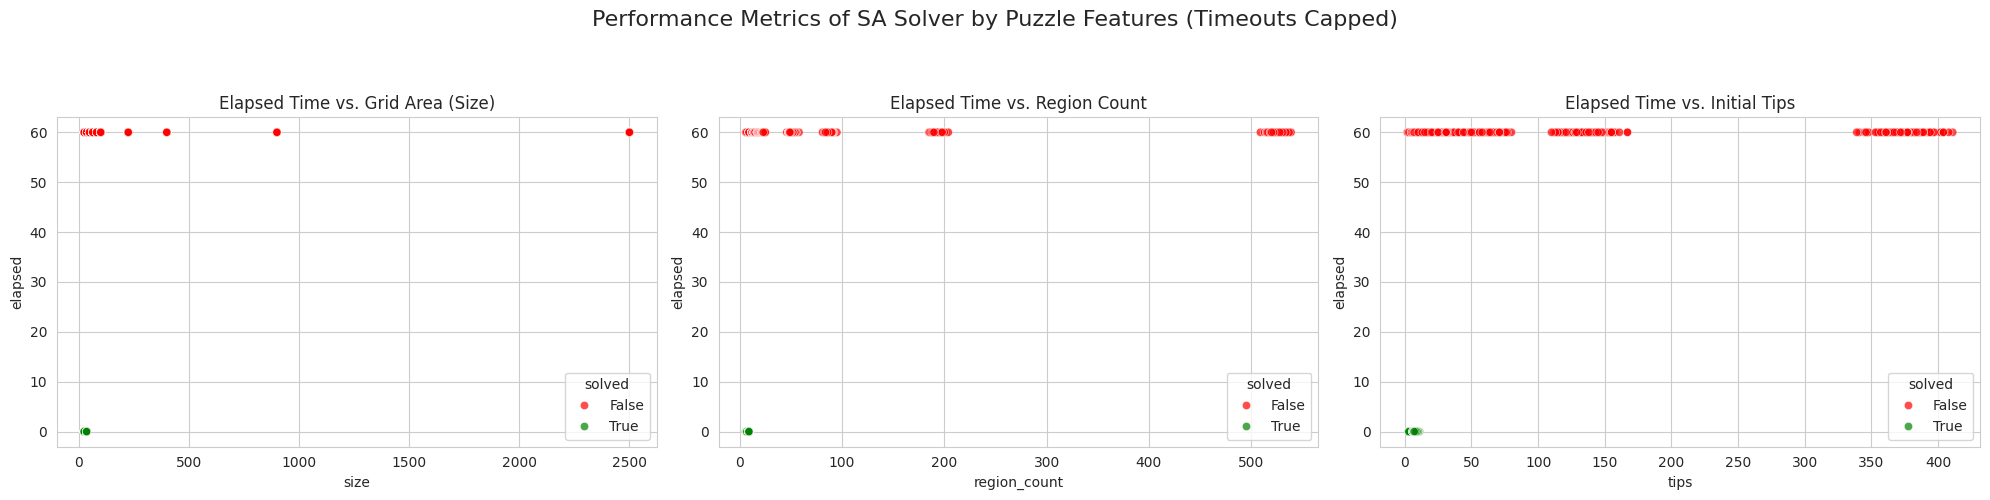

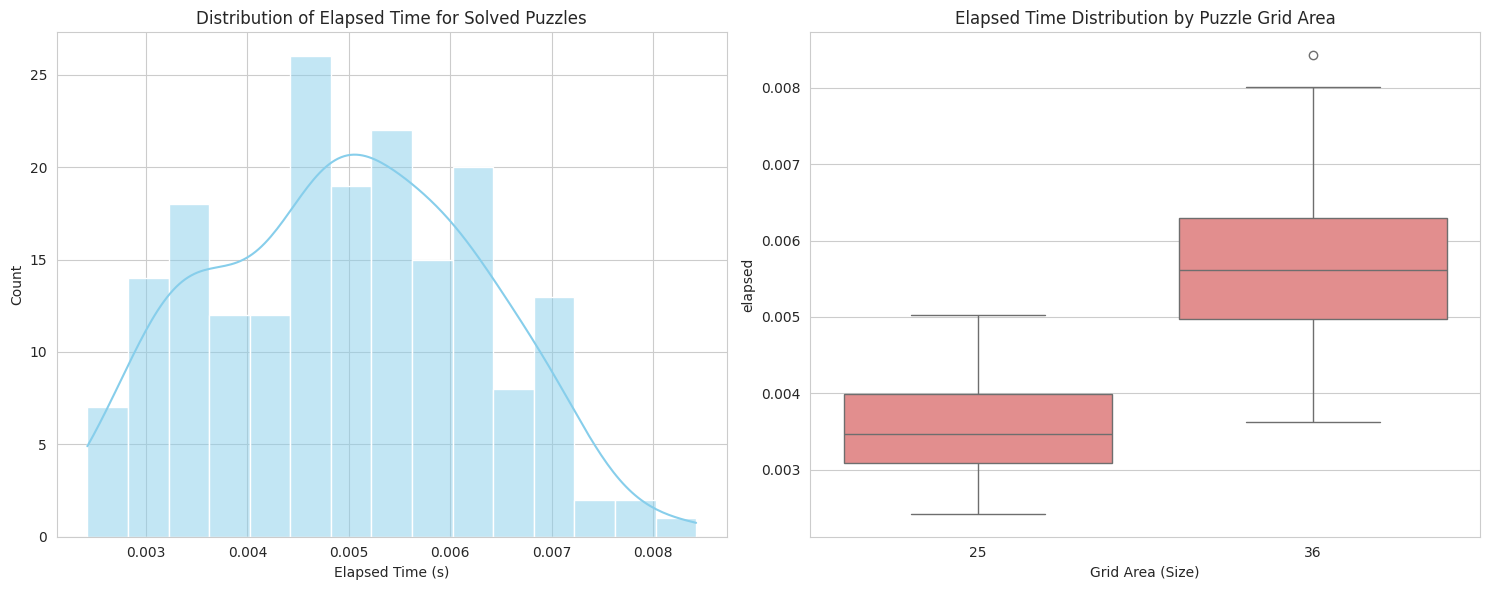

------------------------------
--- Analysis Complete ---


,solved,elapsed,puzzle,tips,size,region_count,timeout,tip_density,region_complexity,log_difficulty_proxy
0,True,0.003915,./instances/generator/5x5_1.data,3,25,9,True,0.1200,2.777778,5.416100
1,True,0.003538,./instances/generator/5x5_2.data,7,25,7,True,0.2800,3.571429,5.164786
2,True,0.003087,./instances/generator/5x5_3.data,5,25,9,True,0.2000,2.777778,5.416100
3,True,0.003009,./instances/generator/5x5_4.data,4,25,8,True,0.1600,3.125000,5.298317
4,False,60.000000,./instances/generator/5x5_6.data,3,25,8,True,0.1200,3.125000,5.298317
...,...,...,...,...,...,...,...,...,...,...
1695,False,60.000000,./instances/generator/50x50_86.data,377,2500,525,True,0.1508,4.761905,14.087444
1696,False,60.000000,./instances/generator/50x50_87.data,377,2500,531,True,0.1508,4.708098,14.098808
1697,False,60.000000,./instances/generator/50x50_88.data,372,2500,528,True,0.1488,4.734848,14.093142
1698,False,60.000000,./instances/generator/50x50_89.data,361,2500,522,True,0.1444,4.789272,14.081714


In [4]:
stats(de_stats)

## Simulated Annealing (Sem paralelismo)

In [5]:
# This might take very long!
#sa_stats = run_solver(SASolver.SASolver)
sa_stats = get_pickle_data('sav2.0.pkl')

--- Starting Data Processing and Feature Engineering ---
Total Runs: 1700, Solved Runs: 1507
------------------------------
--- Key Performance Metrics ---
1. Overall Success Rate: 0.89 (1507/1700)
2. Avg Solving Time (Solved Only): 1.669 s
------------------------------
--- Robust Correlation Analysis ---
Point-Biserial Correlation (r) with SUCCESS RATE:
(* Positive 'r' means higher feature value is correlated with success.)
                      r_success        p_value
tip_density            0.089570   2.174930e-04
region_complexity     -0.395267   1.122469e-64
log_difficulty_proxy  -0.615103  1.649582e-177
tips                  -0.750441  1.106608e-307
region_count          -0.753407  1.809899e-311
size                  -0.754180  1.826883e-312

------------------------------
Pearson Correlation (r) with ELAPSED TIME (Solved Only):
(* Positive 'r' means higher feature value is correlated with longer time.)
                        r_time        p_value
size                  0.727567

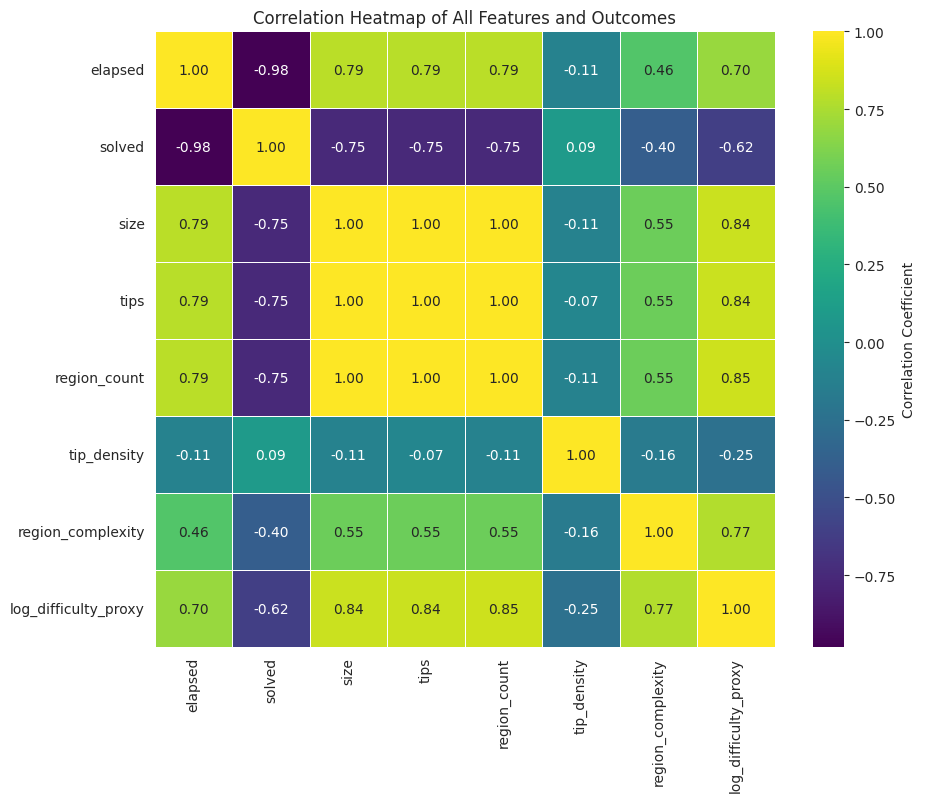


Generating Pair Plot...


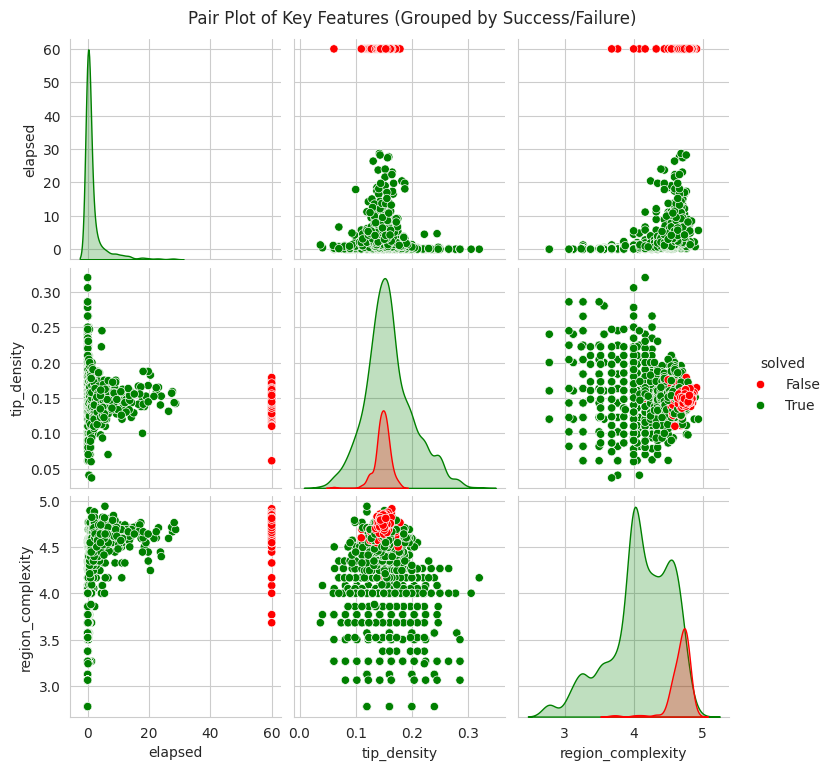

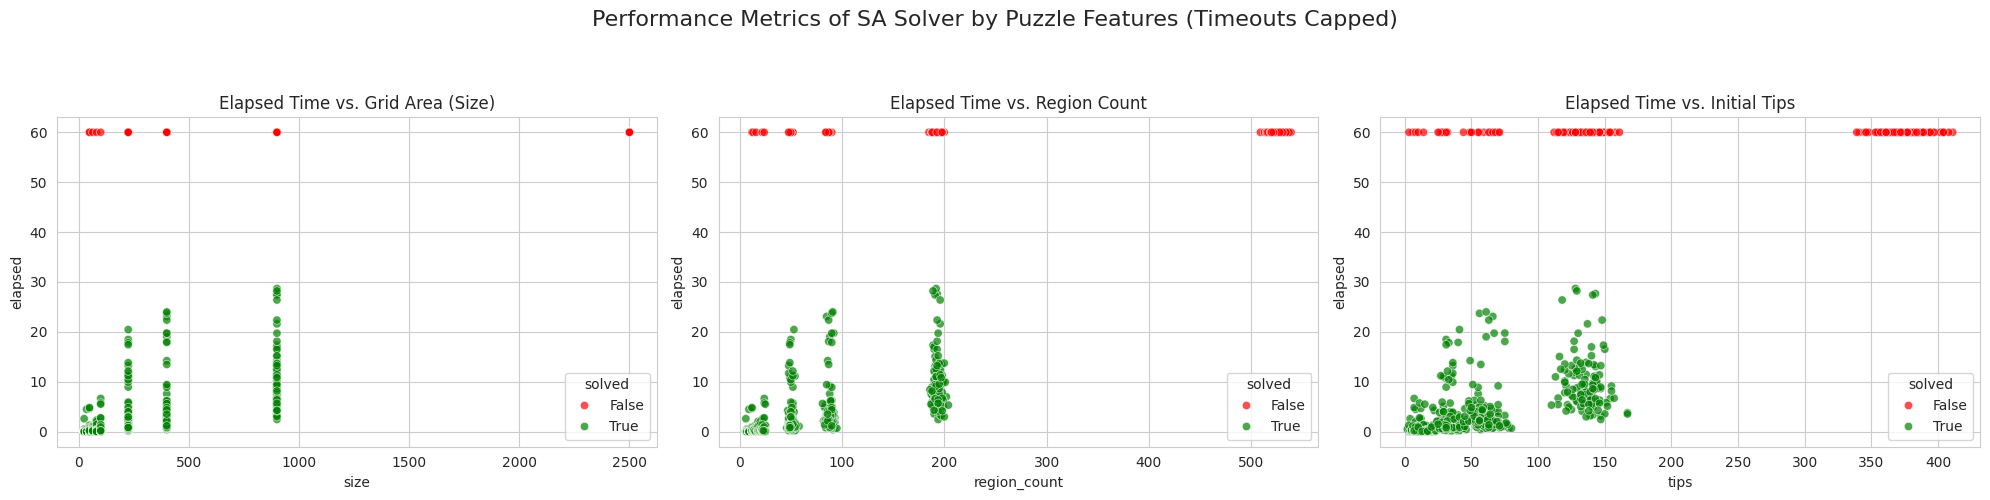

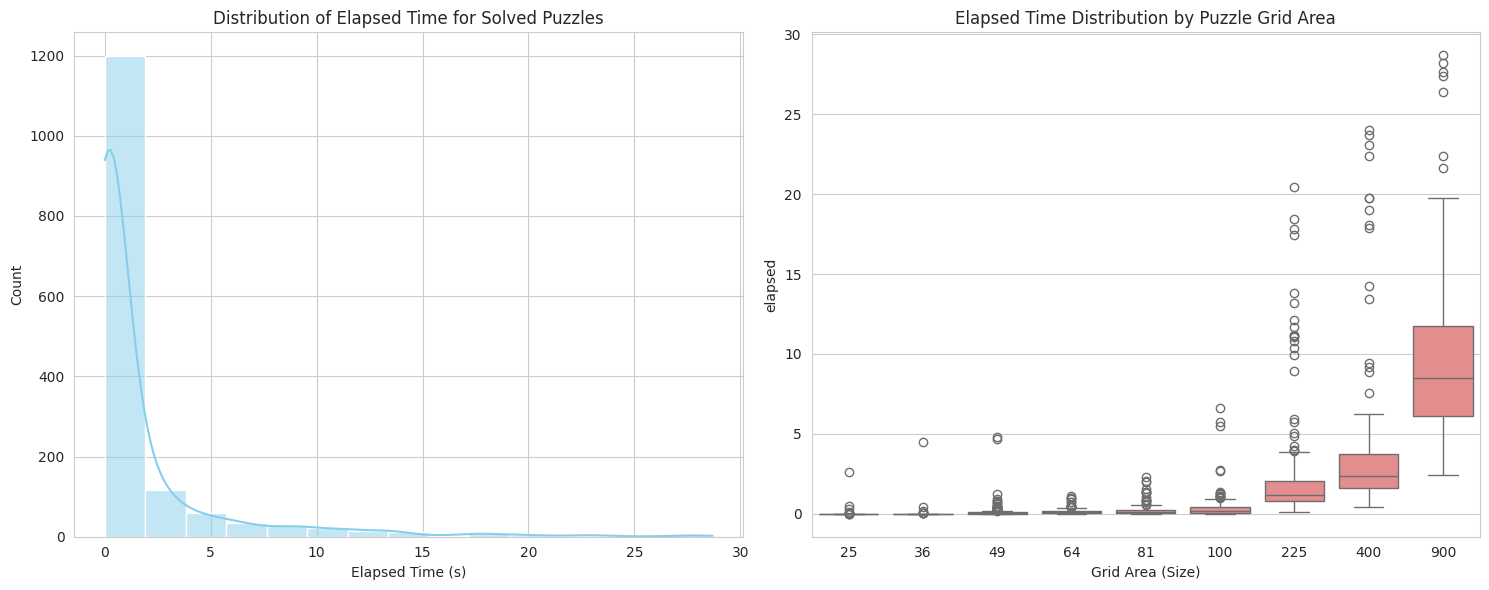

------------------------------
--- Analysis Complete ---


,solved,elapsed,puzzle,tips,size,region_count,timeout,tip_density,region_complexity,log_difficulty_proxy
0,True,0.004549,../../instances/generator/5x5_1.data,3,25,9,True,0.1200,2.777778,5.416100
1,True,0.003846,../../instances/generator/5x5_2.data,7,25,7,True,0.2800,3.571429,5.164786
2,True,0.003432,../../instances/generator/5x5_3.data,5,25,9,True,0.2000,2.777778,5.416100
3,True,0.003855,../../instances/generator/5x5_4.data,4,25,8,True,0.1600,3.125000,5.298317
4,True,0.015421,../../instances/generator/5x5_6.data,3,25,8,True,0.1200,3.125000,5.298317
...,...,...,...,...,...,...,...,...,...,...
1695,False,60.000000,../../instances/generator/50x50_86.data,377,2500,525,True,0.1508,4.761905,14.087444
1696,False,60.000000,../../instances/generator/50x50_87.data,377,2500,531,True,0.1508,4.708098,14.098808
1697,False,60.000000,../../instances/generator/50x50_88.data,372,2500,528,True,0.1488,4.734848,14.093142
1698,False,60.000000,../../instances/generator/50x50_89.data,361,2500,522,True,0.1444,4.789272,14.081714


In [6]:
stats(sa_stats)

## Backtrack (Força Bruta)

In [7]:
# This might take very long!
# bt_stats = evaluate_solver_stats(SuguruSolvers.BacktrackSolver)
bt_stats = get_pickle_data('bt.pkl')

--- Starting Data Processing and Feature Engineering ---
Total Runs: 1700, Solved Runs: 829
------------------------------
--- Key Performance Metrics ---
1. Overall Success Rate: 0.49 (829/1700)
2. Avg Solving Time (Solved Only): 2.222 s
------------------------------
--- Robust Correlation Analysis ---
Point-Biserial Correlation (r) with SUCCESS RATE:
(* Positive 'r' means higher feature value is correlated with success.)
                      r_success        p_value
tip_density            0.293923   3.174229e-35
tips                  -0.485785  2.250868e-101
size                  -0.492557  1.364129e-104
region_count          -0.495192  7.300217e-106
region_complexity     -0.720657  2.016381e-272
log_difficulty_proxy  -0.763584   0.000000e+00

------------------------------
Pearson Correlation (r) with ELAPSED TIME (Solved Only):
(* Positive 'r' means higher feature value is correlated with longer time.)
                        r_time       p_value
size                  0.392721  5

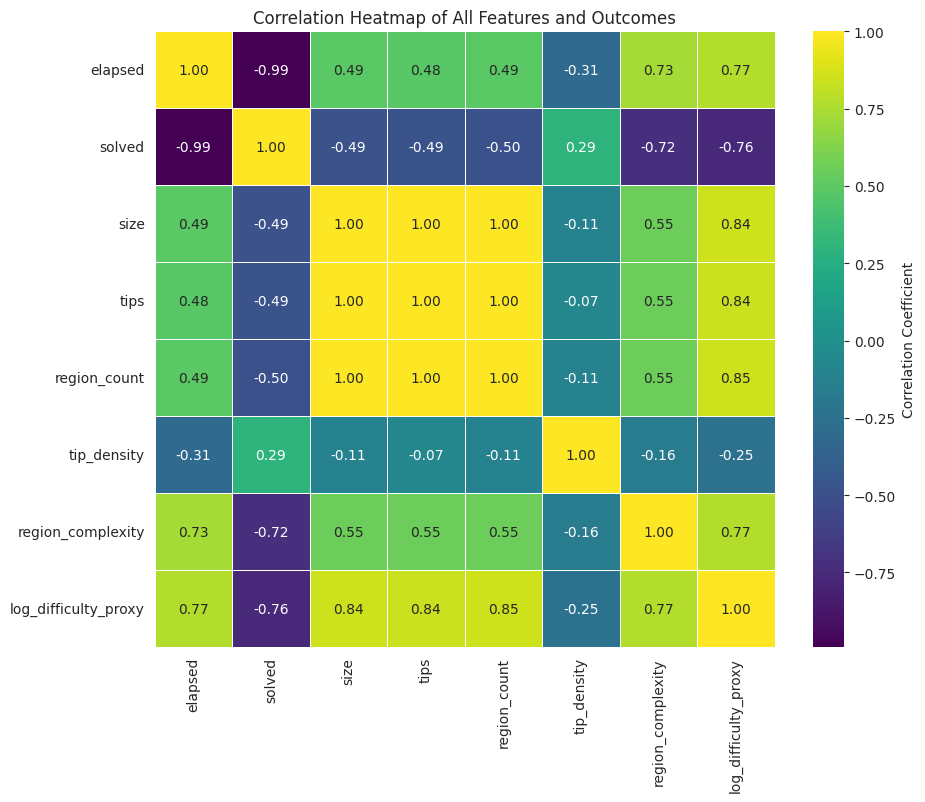


Generating Pair Plot...


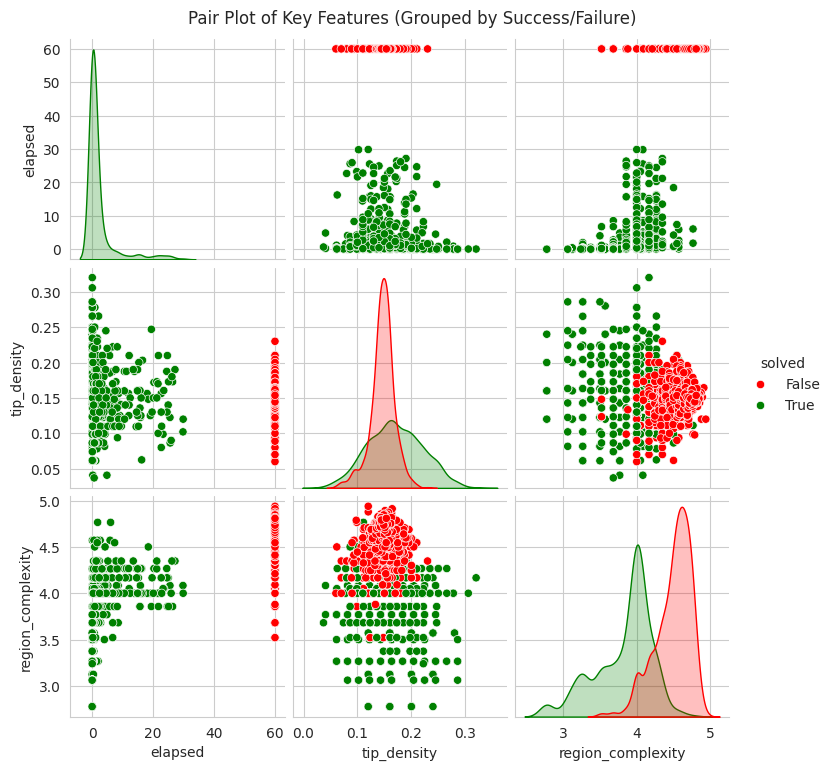

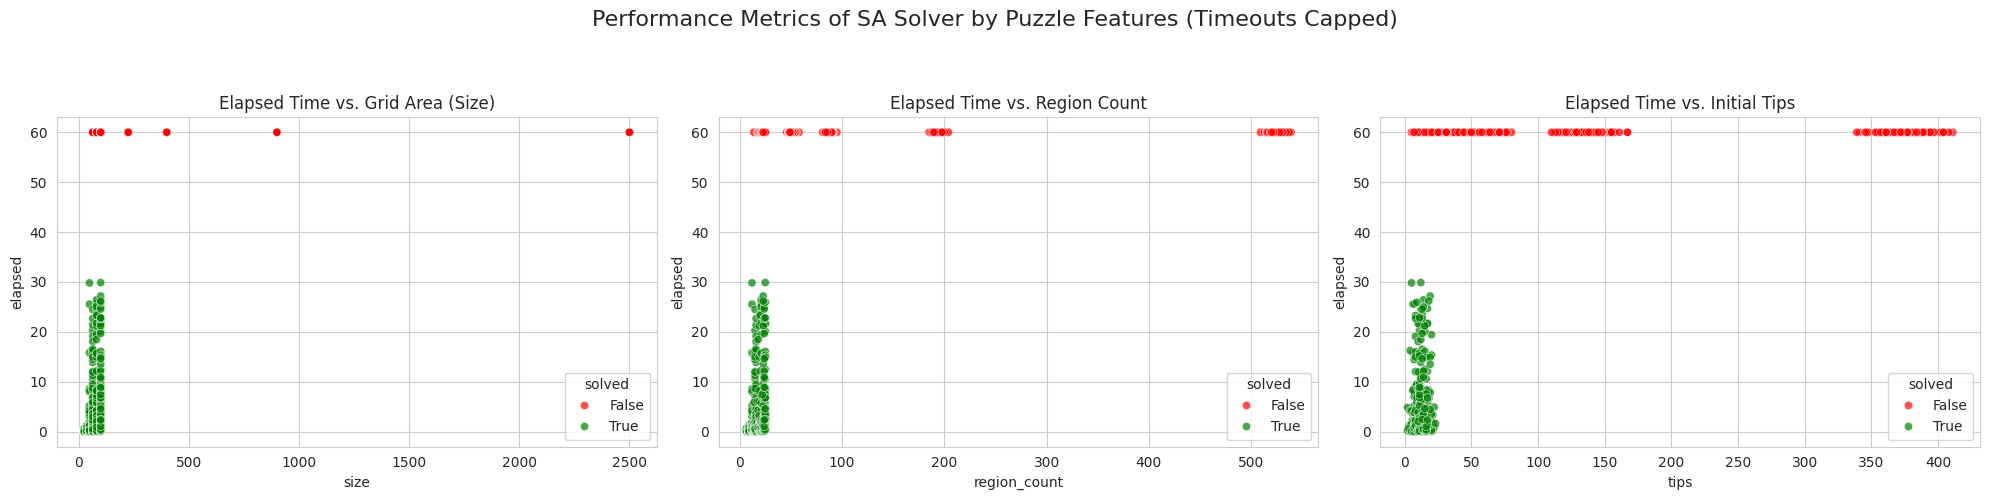

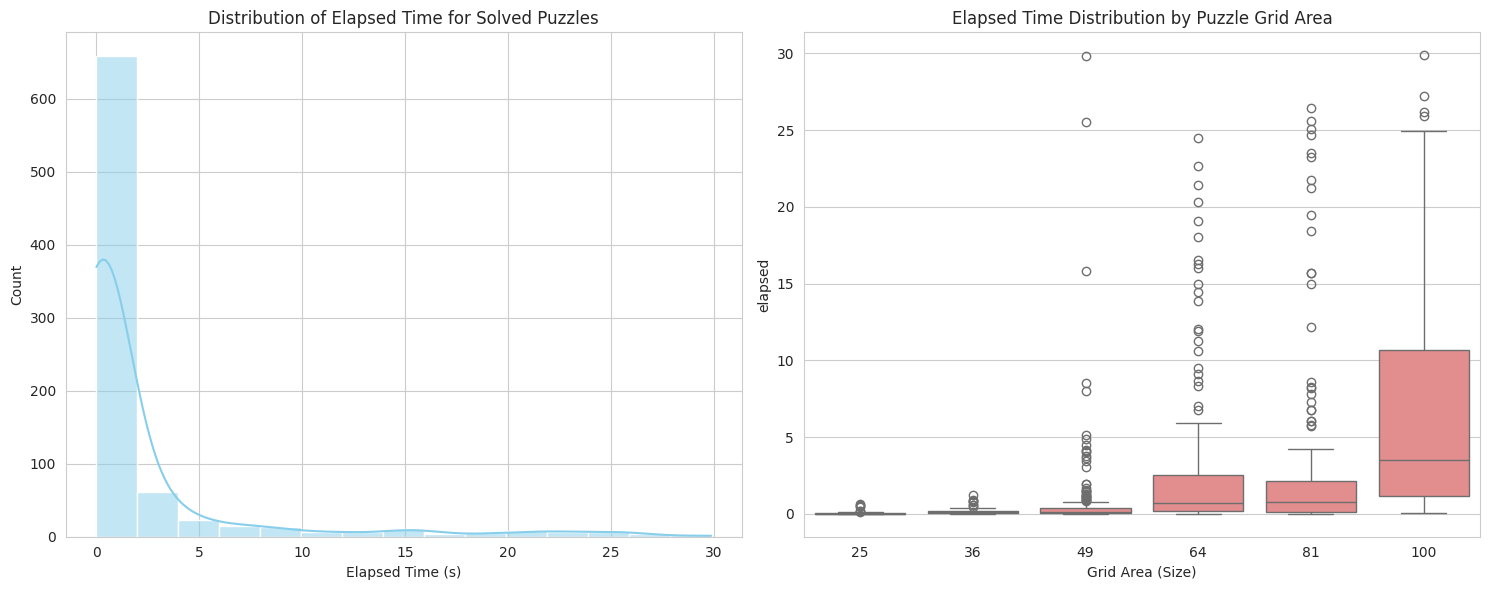

------------------------------
--- Analysis Complete ---


,solved,elapsed,puzzle,tips,size,region_count,timeout,tip_density,region_complexity,log_difficulty_proxy
0,True,0.020590,./instances/generator/5x5_1.data,3,25,9,True,0.1200,2.777778,5.416100
1,True,0.018976,./instances/generator/5x5_2.data,7,25,7,True,0.2800,3.571429,5.164786
2,True,0.004417,./instances/generator/5x5_3.data,5,25,9,True,0.2000,2.777778,5.416100
3,True,0.017991,./instances/generator/5x5_4.data,4,25,8,True,0.1600,3.125000,5.298317
4,True,0.059285,./instances/generator/5x5_6.data,3,25,8,True,0.1200,3.125000,5.298317
...,...,...,...,...,...,...,...,...,...,...
1695,False,60.000000,./instances/generator/50x50_86.data,377,2500,525,True,0.1508,4.761905,14.087444
1696,False,60.000000,./instances/generator/50x50_87.data,377,2500,531,True,0.1508,4.708098,14.098808
1697,False,60.000000,./instances/generator/50x50_88.data,372,2500,528,True,0.1488,4.734848,14.093142
1698,False,60.000000,./instances/generator/50x50_89.data,361,2500,522,True,0.1444,4.789272,14.081714


In [8]:
stats(bt_stats)

## Simulated Annealing (Versão com Paralelismo)

In [9]:
# This might take very long!
#sa_pl = run_solver(SASolver.ParallelSA)
sa_pl = get_pickle_data('sa_optv2.pkl')

--- Starting Data Processing and Feature Engineering ---
Total Runs: 1700, Solved Runs: 964
------------------------------
--- Key Performance Metrics ---
1. Overall Success Rate: 0.57 (964/1700)
2. Avg Solving Time (Solved Only): 2.909 s
------------------------------
--- Robust Correlation Analysis ---
Point-Biserial Correlation (r) with SUCCESS RATE:
(* Positive 'r' means higher feature value is correlated with success.)
                      r_success        p_value
tip_density            0.256003   7.624161e-27
tips                  -0.527946  1.231081e-122
size                  -0.534778  2.259772e-126
region_count          -0.536925  1.453851e-127
region_complexity     -0.638047  5.498088e-195
log_difficulty_proxy  -0.730432  1.793626e-283

------------------------------
Pearson Correlation (r) with ELAPSED TIME (Solved Only):
(* Positive 'r' means higher feature value is correlated with longer time.)
                        r_time        p_value
size                  0.737472  

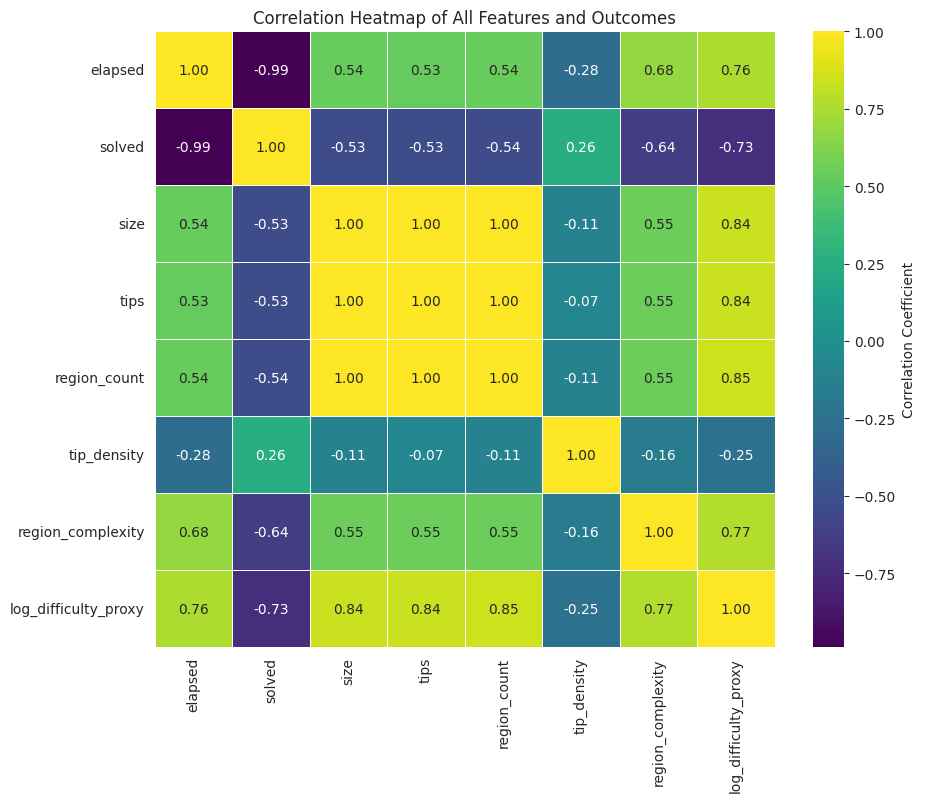


Generating Pair Plot...


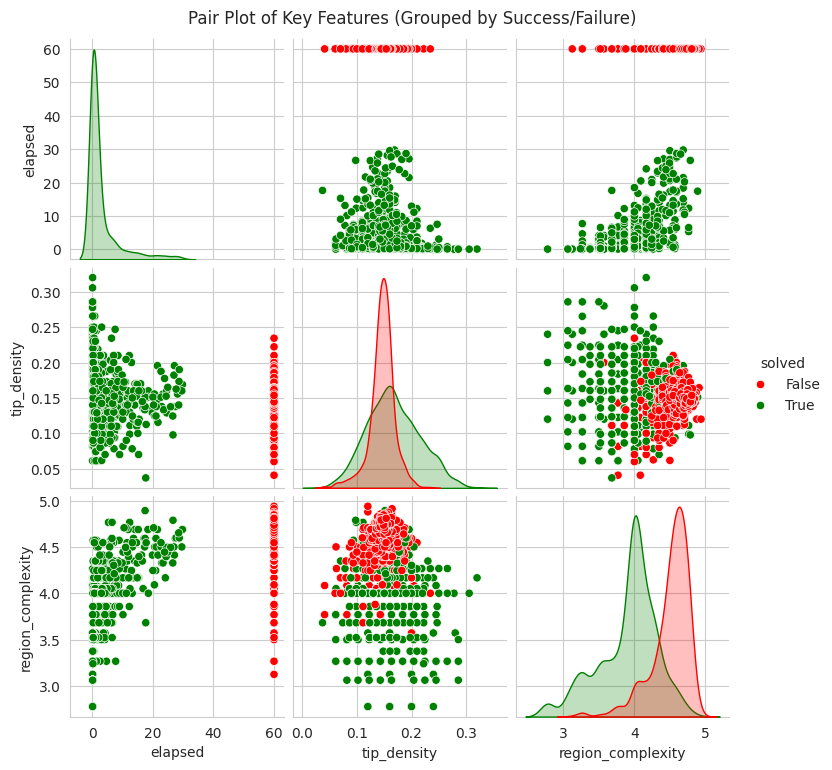

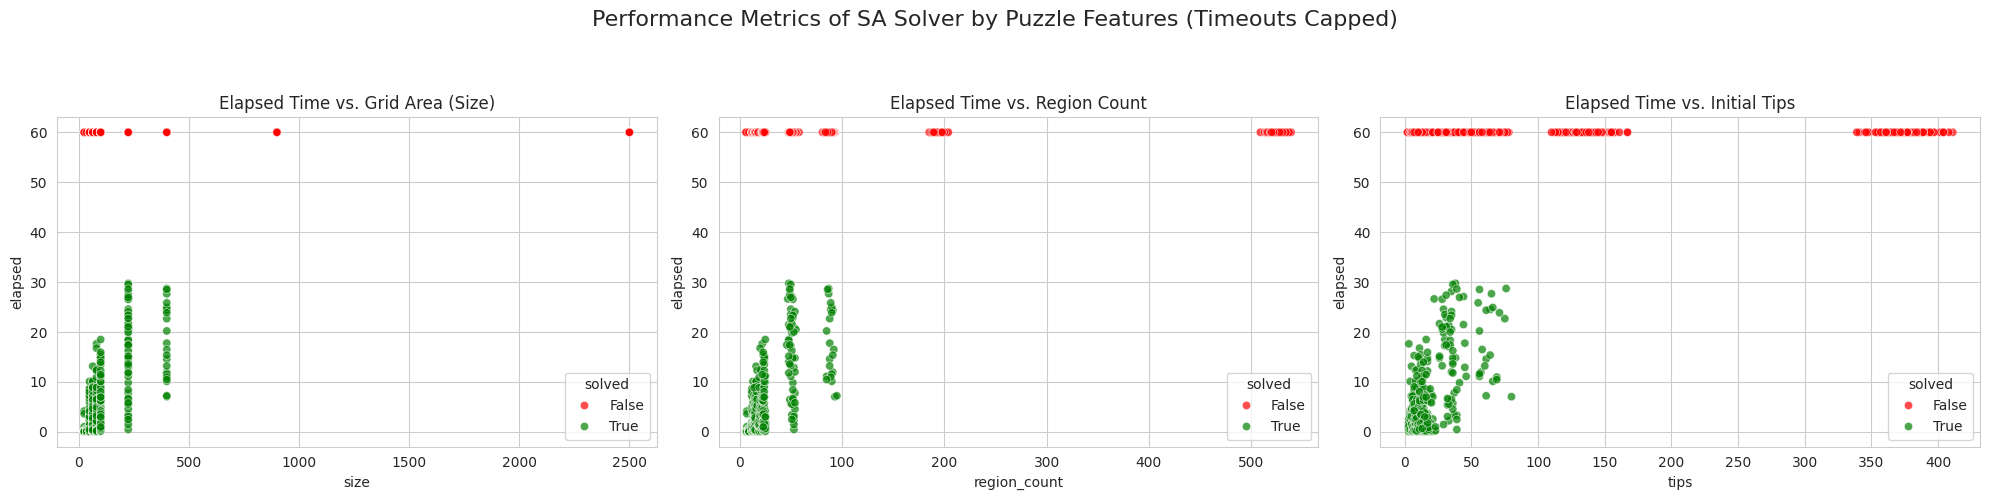

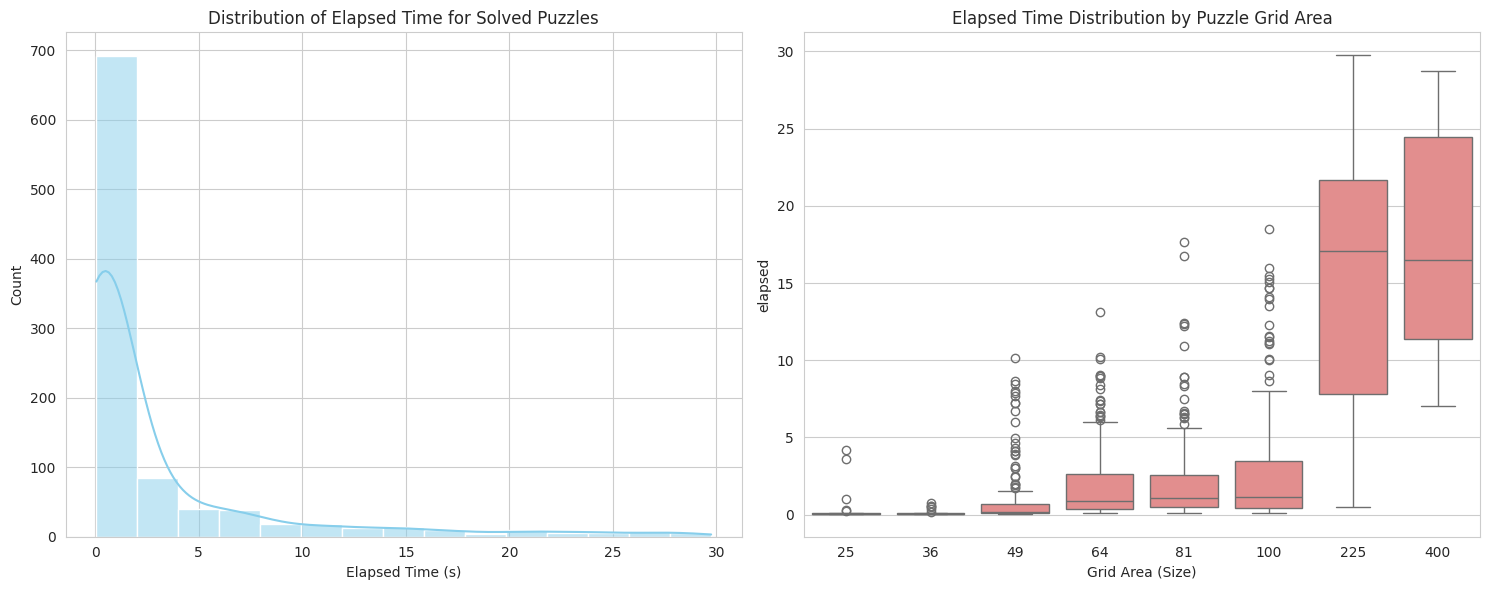

------------------------------
--- Analysis Complete ---


,solved,elapsed,puzzle,tips,size,region_count,timeout,tip_density,region_complexity,log_difficulty_proxy
0,True,0.077128,../../instances/generator/5x5_1.data,3,25,9,True,0.1200,2.777778,5.416100
1,True,0.134894,../../instances/generator/5x5_2.data,7,25,7,True,0.2800,3.571429,5.164786
2,True,0.091304,../../instances/generator/5x5_3.data,5,25,9,True,0.2000,2.777778,5.416100
3,True,0.055342,../../instances/generator/5x5_4.data,4,25,8,True,0.1600,3.125000,5.298317
4,False,60.000000,../../instances/generator/5x5_6.data,3,25,8,True,0.1200,3.125000,5.298317
...,...,...,...,...,...,...,...,...,...,...
1695,False,60.000000,../../instances/generator/50x50_86.data,377,2500,525,True,0.1508,4.761905,14.087444
1696,False,60.000000,../../instances/generator/50x50_87.data,377,2500,531,True,0.1508,4.708098,14.098808
1697,False,60.000000,../../instances/generator/50x50_88.data,372,2500,528,True,0.1488,4.734848,14.093142
1698,False,60.000000,../../instances/generator/50x50_89.data,361,2500,522,True,0.1444,4.789272,14.081714


In [10]:
stats(sa_pl)